# Map

In [2]:
import geopandas as gpd
import pandas as pd
import re
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("data.csv")

In [4]:
case = df.iloc[:, [0, 2]]
case.columns = ["Count", "Location"]
case.loc[:, "City"] = case.Location.apply(lambda x: re.findall(r"\w+", x)[0])
case.loc[:, "Province"] = case.Location.apply(lambda x: re.findall(r"\w+", x)[1])
case.loc[case.Province == "Inner", "Province"] = "Nei Mongol"
case.loc[case.Province == "Ningxia", "Province"] = "Ningxia Hui"
case.loc[case.Province == "Xinjiang", "Province"] = "Xinjiang Uygur"

In [5]:
case.iloc[26, [2, 3]] = ["Yan'an", "Shaanxi"]
case.iloc[40, [2, 3]] = ["Pu'er", "Yunnan"]
case.iloc[146, [2, 3]] = ["Guang'an", "Sichuan"]
case.iloc[224, [2, 3]] = ["Lu'an", "Anhui"]
case.iloc[233, [2, 3]] = ["Huai'an", "Jiangsu"]
case.iloc[260, [2, 3]] = ["Xi'an", "Shaanxi"]
case.iloc[137, [2, 3]] = ["Ma'anshan", "Anhui"]

In [25]:
case[case.Province.apply(lambda x: len(x) < 5)]
# case[case.City.apply(lambda x: len(x) < 5)]

,Count,Location,City,Province


In [6]:
m = gpd.read_file('map/CHN_adm2.shp', encoding="utf8")

In [8]:
m.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,HASC_2,CCN_2,CCA_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry
0,49,CHN,China,1,Anhui,1,Anqing,None,0,None,Dìjíshì,Prefecture City,安庆市,Ānqìng,"POLYGON ((117.11557 31.16616, 117.11788 31.160..."
1,49,CHN,China,1,Anhui,2,Bengbu,None,0,None,Dìjíshì,Prefecture City,蚌埠市,Bèngbù,"POLYGON ((117.26205 33.49959, 117.28395 33.497..."
2,49,CHN,China,1,Anhui,3,Bozhou,None,0,None,Dìjíshì,Prefecture City,亳州市,Bózhōu,"POLYGON ((115.73950 34.07428, 115.74284 34.072..."
3,49,CHN,China,1,Anhui,4,Chaohu,None,0,None,Dìjíshì,Prefecture City,巢湖市,Cháohú,"POLYGON ((118.36978 31.92897, 118.37383 31.924..."
4,49,CHN,China,1,Anhui,5,Chizhou,None,0,None,Dìjíshì,Prefecture City,池州市,Chízhōu,"POLYGON ((117.97800 30.82234, 117.97175 30.816..."


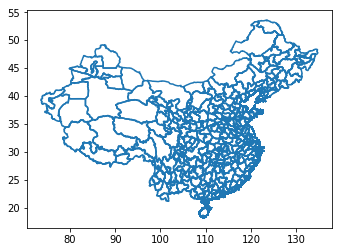

In [61]:
m.boundary.plot();

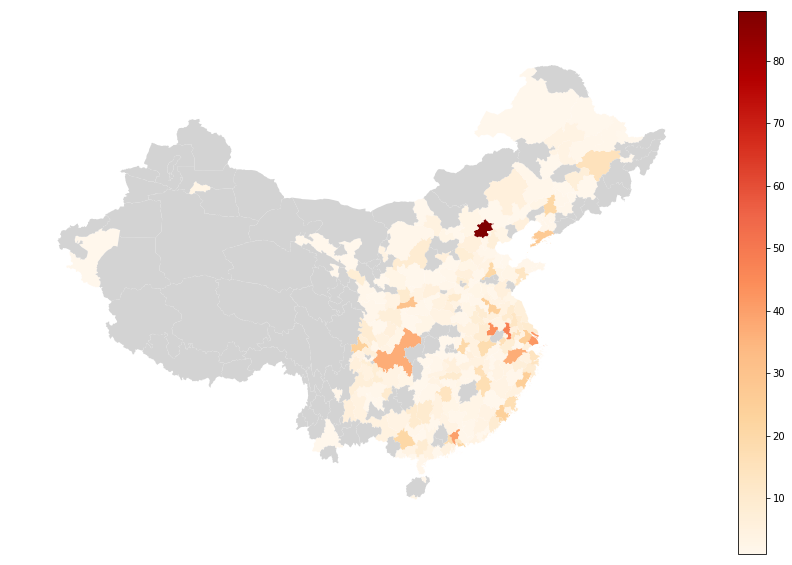

In [7]:
merged_df = pd.merge(m, case, left_on = "NAME_2", right_on = "City", how = "outer")
merged_df.plot(column = "Count",
               cmap = "OrRd",
               legend = True,
               figsize=(15, 10),
               missing_kwds={"color": "lightgrey",
                             #"hatch": "///",
                             "label": "Missing values"})
plt.axis("off");

In [63]:
m_copy = m.iloc[:, [4, 6]]
m_copy.columns = ["Province", "City"]

In [64]:
m_copy[m_copy.Province == "Shanghai"]

,Province,City
260,Shanghai,Shanghai


# WORD CLOUD

In [8]:
import jieba
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from wordcloud import WordCloud

In [9]:
jieba.load_userdict("word_dictionary.txt")

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.986 seconds.
Prefix dict has been built successfully.


In [10]:
df = pd.read_csv("matches.csv")
gb = df.groupby("location").sum()
gb.head()

,case
location,
七台河市,黑龙江七台河出租车司机用低价车费诱18岁少女上车将其强暴
三亚市,海南三亚一男子分手后盗走前女友多件金首饰海南三亚湾美丽新海岸附近一男司机林某猥亵乘客被警方拘...
三明市,福建三明明溪男子余某翔在厦门杀女友，砍杀岳母
三门峡市,河南三门峡一男子杀害妻子岳母等5人后坠亡
上海市,上海东华大学04级研究生章胜偷窥女生如厕上海财经大学副教授钱逢胜被曝性侵女学生上海海事大学解...


In [16]:
S = ["女", "诱", "打", "脱", "怼", "杀", "捅", "刺", "刀", "锤", "死", "跳", "伤", "摸", "砖", \
     "蹭", "骗", "扔", "掐", "骗", "砍", "赔", "跑", "胸", "拘", "追", "抛", "扇", "打", "怒", \
     "剁", "抱", "摸", "弃", "拽", "腰", "拍", "藏", "手", "尸", "戳", "弑", "腿", "家", "村", \
     "逼", "灌", "哭", "臀", "闯", "划", "脸", "摔", "吓", "断", "捂", "娶", "拍", "镇", "狠", \
     "抡", "拒", "掳", "偷", "钱", "揍", "车", "藏", "拉", "勒", "泼", "踹", "头", "颈", "勒", \
     "鼻", "车", "牢", "扒", "泼", "电", "掌", "掴", "砸", "暴", "塞", "母", "烧", "趁", "剐", \
     "吻", "背", "卖", "玩", "逃", "摔", "旅", "浇", "抡", "爬", "妻", "河", "摔", "持", "球", \
     "楼", "美", "性", "孝", "喜", "险", "男", "骑", "挑", "戴", "裤", "血", "救", \
     "病", "亲", "欠", "聊", "挠", "露"]

def text_processor(text):
    text = re.sub(r"[\W\d]", "", text)
    lst = []
    for word in jieba.cut(text):
        if (len(word) > 1) or (word in S):
            lst.append(word)
    return " ".join(lst)

word_lst = pd.DataFrame(gb.case.apply(lambda x: text_processor(x)))

In [17]:
word_lst.head()

,case
location,
七台河市,黑龙江 七台河 出租车 司机 低价 车费 诱岁 少女 上车 强暴
三亚市,海南 三亚 男子 分手 盗走 前女友 多件 首饰 海南 三亚湾 美丽 海岸 附近 一男 司机...
三明市,福建 明明 男子 某翔 厦门 杀 女友 砍杀 岳母
三门峡市,河南 三门峡 男子 杀害 妻子 岳母 人后 坠亡
上海市,上海 东华大学 研究生 章胜 偷窥女生 如厕 上海财经大学 副教授 钱逢胜 性侵 女学生 上...


In [18]:
s = word_lst.iloc[4, 0]
s

'上海 东华大学 研究生 章胜 偷窥女生 如厕 上海财经大学 副教授 钱逢胜 性侵 女学生 上海 海事 大学 解聘 外语学院 院长 蒋林 性侵 女生 上海师范大学 信息 机电 工程学院 汽车 服务 工程 专业 本科班 学生 胡晨龙 学校 东门 公交站 偷拍 女性 开除 学籍 复旦大学 附属 妇产科 医院 女 医护 准备 黄体酮 推迟 月经 院方 自愿 使用 上海戏剧学院 教务处 处长 厉震林 性骚扰 链接 女学生 HYD 博导 凌昌全 教授 十五年 骚扰 打击报复 逼迫 就范 上海 闵行 男子 齐某 多次 骚扰 侮辱 前妻 锁匠 前妻 房门 上海 丈夫 俞峒 妻子 徐冰 推下楼 冷眼旁观 威胁 路人 多管闲事 上海 徐汇区 女子 离婚 丈夫 打 毁容 上海浦东新区 男子 严某 欠债 杀妻 纵火 上海 宝山区 男子 吴某 骗领 养老金 病逝 母亲 藏于 冰柜 数月 上海 松江县 西旺村 男子 何雪龙 杀害 妻子 娘家 五口 上海 宝山区 男子 黄某 杀害 妻子 岳母 上海 普陀区 男子 冯某 女友 熟睡 解锁 手机 偷买 七千元 电子产品 女友 报警 男子 刑拘 上海 男子 凌晨 路边 性侵 女子 路人 见义勇为 制止 耳朵 咬伤 上海 男子 杀害 肢解 女同事 藏尸 十六年 上海 七宝 万科 弗里 书店 十岁 男孩 监控 死角 怼 陌生 五岁 女孩 性骚扰 脱 衣裤 乱摸 猥亵 上海 杨浦区 畅想 艺术 幼稚园 男子 张某 猥亵 女童 上海 福定 小区 男子 刘某 女友 吵架 牛肉 楼窗口 扔下 砸烂 轿车 挡风玻璃 上海 男子 邓某 赌博 妻离子散 怪罪 妻子 同事 深夜 袭击 报复 对方 上海 司机 陈某 女乘客 墓地 企图 性侵 上海 女子 私处 美容 发现 正前方 就是 监控 探头 上海交大 院长 谢耘 因涉 性骚扰 撤职 上海 女子 前男友 骚扰 报案 发现 竟是 逃犯 上海 focusmodels 模特 经纪 公司 模特 疯狂 约炮 骗炮 数十 上海 外地 男子 陈某 砍断 妻子 手掌 判刑 四年 上海浦东新区 男子 狠心 杀妻 儿女 后割 脖子 自刎 上海 杨浦区 鞍山 四村 男子 母亲 吵架 酒瓶 放火 上海 初二 女生 遭到 生父 多次 性侵 生母 帮忙 捂嘴 上海浦东新区 春晖 小区 男子 黄某 残忍 杀害 姐姐 夫妻俩 上海浦东新区 男子 李某

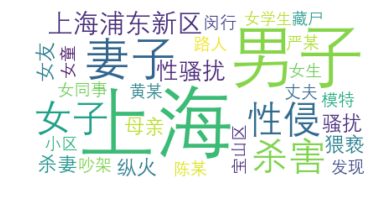

In [24]:
word_cloud = WordCloud(
    background_color="white",
    max_words=30,
    font_path="Deng.ttf").generate(s)

plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [8]:
import folium

/home/student/.local/lib/python3.5/site-packages/OpenSSL/crypto.py:14: CryptographyDeprecationWarning: Python 3.5 support will be dropped in the next release of cryptography. Please upgrade your Python.
  from cryptography import utils, x509


In [ ]:
M = folium.Map(location=[37, 105], zoom_start=4)

folium.Choropleth(
    geo_data="output.json",
    data=merge,
    columns=["City", "Count"],
    key_on="feature.ID",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Count").add_to(M)

folium.LayerControl().add_to(M)

M

In [9]:
merge = merged_df.iloc[:, [5, 14, 15, 17]]
merge.columns = ["ID", "geometry", "Count", "City"]
merge.head()

,ID,geometry,Count,City
0,1.0,"POLYGON ((117.11557 31.16616, 117.11788 31.160...",18.0,Anqing
1,2.0,"POLYGON ((117.26205 33.49959, 117.28395 33.497...",6.0,Bengbu
2,3.0,"POLYGON ((115.73950 34.07428, 115.74284 34.072...",9.0,Bozhou
3,4.0,"POLYGON ((118.36978 31.92897, 118.37383 31.924...",NaN,NaN
4,5.0,"POLYGON ((117.97800 30.82234, 117.97175 30.816...",2.0,Chizhou


In [9]:
merge.to_file("output.json", driver="GeoJSON")